In [1]:
import pandas as pd
import numpy as np
from proposal_code import all_craters, tiles
from test_human import remove_ticks
import matplotlib.pyplot as plt
from skimage.draw import circle
from PIL import Image
import random
import string
import os

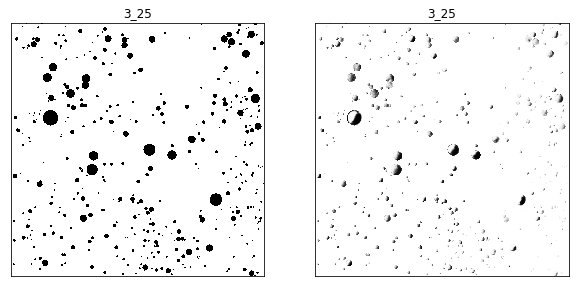

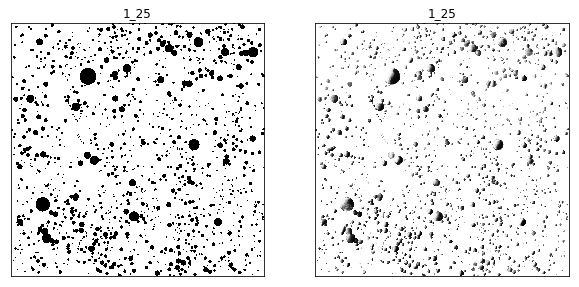

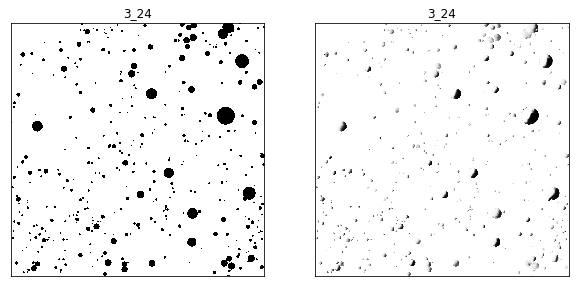

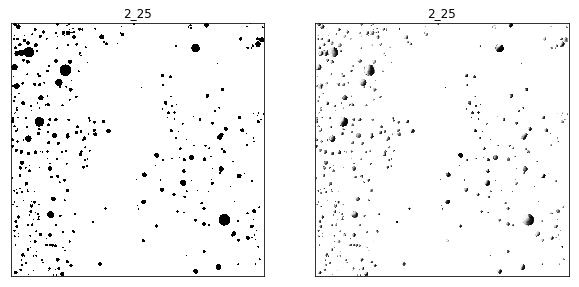

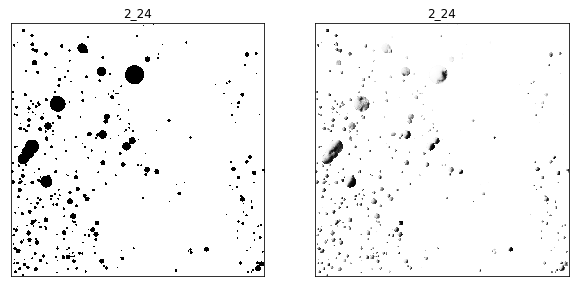

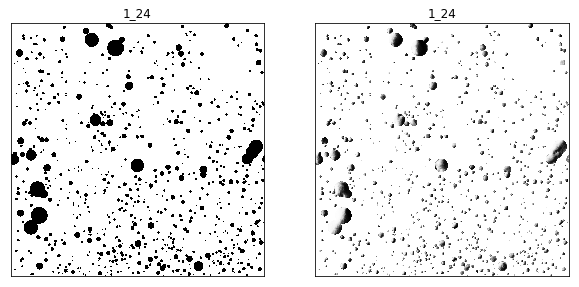

In [2]:
def build_target(craters):
    """Takes a list of craters and returns a mask image, 1700x1700 with binary pixels;
    0 is non-crater, 1 is crater.
    """
    size = (1700, 1700)
    image = np.zeros(size, dtype='uint8')
    for i, crater in craters.iterrows():
        x = crater['x']
        y = crater['y']
        r = crater['d']/2
        if r < 80:
            rr, cc = circle(y, x, r)
            try:
                image[rr, cc] = 255
            except:
                pass
    return image

path = './tiles/mask/'
for tile in tiles:
    mask = build_target(all_craters[all_craters.tile==tile])
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].set_title(tile)
    ax[0].imshow(mask, cmap='Greys');
    ax[0] = remove_ticks(ax[0])
    ax[1].set_title(tile)
    ax[1].imshow(np.where(mask==255, tiles[tile], 0), cmap='Greys');
    ax[1] = remove_ticks(ax[1])
    image = Image.fromarray(mask)
    image.save(path + '{}_mask.bmp'.format(tile))

In [3]:
tf_dir = './tiles/t_tiles/'

In [4]:
def random_id(K=5):
    """Returns a string of random characters (numeric and upper alpha)
    of length K"""
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(K))

id_set = set([random_id(K=7) for x in range(20000)])

In [5]:
def crop_square(input_image, side_length, orgn=(0,0)):
    """Crops a sqaure from input_image and returns the cropped image.
    Requires input image and side_length (n pixels), defaults to origin
    at (0, 0) (top-left corner of input image)
    """
    if type(input_image) == type(np.array):
        input_image = Image.fromarray(input_image)
    left = orgn[0]
    upper = orgn[1]
    right = left + side_length
    lower = upper + side_length
    box = (left, upper, right, lower)
    return input_image.crop(box)

def simul_crop(input_image, mask, side_length, orgn=(0,0)):
    """simultaneously crops input image and its accompanying mask.
    returns cropped squares of image, mask.
    """
    image_output = crop_square(input_image, side_length, orgn=orgn)
    mask_output = crop_square(mask, side_length, orgn=orgn)
    return image_output, mask_output

def get_coords(length, window_size, overlap=0):
    """Function to calculate origin coordinates given a user-specified
    window size, overlap, and dimension length. Returns a list of
    coordinate values; the last image will be cropped from the location
    that does not cut off the image, regardless of window/overlap sizes.
    """
    result = []
    step_size = window_size - overlap
    current_pos = 0
    #advance coordinates by step_size until image out of frame.
    while length > current_pos + window_size:
        result.append(current_pos)
        current_pos += step_size
    #Ideal scenario: last frame is exactly window size
    if length == current_pos + window_size:
        result.append(current_pos)
    #More common: last frame is up against edge of master image
    elif length < current_pos + window_size:
        result.append(length - window_size)
    return result

def split_tile(input_tile, input_mask, window_size=256, overlap=0, save_output='./tiles/keras_folders/', id_set=id_set):
    """Takes a tile and its accompanying mask and splits it into
    cropped square images. Default saves tiles to ./tiles/tf_tiles/.
    Input images have a 7-digit id, their mask coutnerparts have same
    id with '_mask' added. Outputs .tif extensions.
    """
    width = input_tile.size[0]
    height = input_tile.size[1]
    x_coords = get_coords(width, window_size, overlap)
    y_coords = get_coords(height, window_size, overlap)
    total = 0
    for y in y_coords:
        for x in x_coords:
            un_id = id_set.pop()
            img, img_mask = simul_crop(input_tile, input_mask, side_length=window_size, orgn=(x, y))
            img_path = save_output+'/'+un_id+'.png'
            #save input image to path
            img.save(img_path)
            #crop mask again to match 172x172 model output
            img_mask = crop_square(img_mask, side_length=172, orgn=(42,42))
            mask_path = save_output+'_mask/'+un_id+'_mask.png'
            img_mask.save(mask_path)
            total += 1
    print('created {} image/mask pairs.'.format(total))
    return id_set



In [6]:
output_base_path='./tiles/keras_folders/'

#5 tiles for training
mask_1_24 = Image.open('./tiles/mask/1_24_mask.bmp')
mask_1_25 = Image.open('./tiles/mask/1_25_mask.bmp')
mask_2_24 = Image.open('./tiles/mask/2_24_mask.bmp')
mask_3_24 = Image.open('./tiles/mask/3_24_mask.bmp')
mask_3_25 = Image.open('./tiles/mask/3_25_mask.bmp')
#id_set = split_tile(tiles['1_24'], mask_1_24, window_size=256, overlap=84, save_output=output_base_path+'train', id_set=id_set)
#id_set = split_tile(tiles['1_25'], mask_1_25, window_size=256, overlap=84, save_output=output_base_path+'train', id_set=id_set)
#id_set = split_tile(tiles['2_24'], mask_2_24, window_size=256, overlap=84, save_output=output_base_path+'train', id_set=id_set)
#id_set = split_tile(tiles['3_24'], mask_3_24, window_size=256, overlap=84, save_output=output_base_path+'train', id_set=id_set)
#id_set = split_tile(tiles['3_25'], mask_3_25, window_size=256, overlap=84, save_output=output_base_path+'train', id_set=id_set)

#one for validation
mask_2_25 = Image.open('./tiles/mask/2_25_mask.bmp')
#id_set = split_tile(tiles['2_25'], mask_2_25, window_size=256, overlap=84, save_output=output_base_path+'test', id_set=id_set)

In [7]:
def pad_mask(mask):
    """Takes a 172x172 mask and pads it with zeros to center on
    its accompanying image.
    """
    null_arr1 = np.zeros((42, 256))
    null_arr2 = np.zeros((172, 42))
    null_arr3 = null_arr2.copy()
    null_arr4 = null_arr1.copy()
    concat_1 = np.concatenate([null_arr2, mask, null_arr3], axis=1)
    return np.concatenate([null_arr1, concat_1, null_arr4], axis=0)

def overlay_mask(id_no, train=True):
    """Fetches image and accompanying mask and overlays them. Confirms mask
    is properly generated.
    """
    path = './tiles/keras_folders/'
    if train:
        path += 'train/'
    else:
        path += 'test/'
    img = np.array(Image.open(path+'{}.png'.format(id_no)))
    mask = np.array(Image.open(path[:-1]+'_mask/{}_mask.png'.format(id_no)))
    mask = pad_mask(mask)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='Greys', alpha=1);
    ax.imshow(mask, cmap='viridis', alpha=.15);
    ax = remove_ticks(ax)
    ax.set_title('Target "ground truth" overlaid on input image')

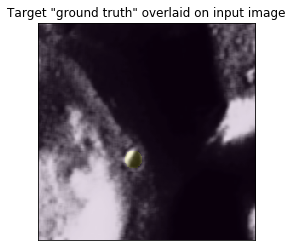

In [8]:
overlay_mask('PAWX9VM', train=False)

In [26]:
masks = [mask_1_24, mask_1_25, mask_2_24, mask_2_25, mask_3_24, mask_3_25]
masks = [np.array(x)/255 for x in masks]
masks = [(x.sum().sum()/(x.shape[0]*x.shape[1])) for x in masks]
crater_percentage = np.array(masks).mean()

In [27]:
del mask_1_24, mask_1_25, mask_2_24, mask_2_25, mask_3_24, mask_3_25